# Sprawozdanie z zajęć nr 10
### Mateusz Stelmaszek
### 80275

# Przygotowujemy środowisko !

In [2]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-ua8eks3t
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-ua8eks3t
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=0dbdfacf90db80b4c905f653a7b230fc0c52a522fc477ef5431dd57b7d21f148
  Stored in directory: /tmp/pip-ephem-wheel-cache-3nli1jko/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
cr

In [3]:
!apt-get install gnuplot
!pip install matplotlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aglfn gnuplot-data gnuplot-qt liblua5.3-0 libqt5svg5 libwxbase3.0-0v5
  libwxgtk3.0-gtk3-0v5
Suggested packages:
  gnuplot-doc
The following NEW packages will be installed:
  aglfn gnuplot gnuplot-data gnuplot-qt liblua5.3-0 libqt5svg5
  libwxbase3.0-0v5 libwxgtk3.0-gtk3-0v5
0 upgraded, 8 newly installed, 0 to remove and 23 not upgraded.
Need to get 6,713 kB of archives.
After this operation, 25.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libqt5svg5 amd64 5.12.8-0ubuntu1 [131 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 aglfn all 1.7+git20191031.4036a9c-2 [30.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 gnuplot-data all 5.2.8+dfsg1-2 [56.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/main amd64 liblua5.3-0 amd64 5.3.3-1.1ubuntu2 [116 k

# Poniższe programy liczą wynik całki 3 sposobami: Metoda prostokątów, trapezów oraz simpsona, każda z metod posiada program liczący ją za pomocą:
# CPU - procesor 
# GPU - karta graficzna
# Poznajmy podstawy które są zastosowane w programach !

1. %%cu - pozwala na kompilowanie poniższych kodów CUDA w środowisku GoogleCollab
2. W celu policzenia całki (ma to też wpływ na wynik im wiekszy przedział tym bardziej dokładny wynik) całkę dzielimy na przedziały, których ilość zawiera się w zmiennej 'N'
3. Dzięki pętli wyliczamy wartość w konkrętnym miejscu funkcji (parametr i wyznacza to miejsce)
4. Zmienna 'sum' jest sumą wartości funkcji, dzielimy ją przez liczbę N - liczba przedziałów 
5. Funkcja licz - służy do policzenia wartości pola pod całką
6. Fukcja main to w niej wywołujemy fukcję oraz liczymy czas wykonania programu

# Jak działają poszczególne metody?

# Metoda Prostokątów:
    Ta metoda wykorzystuję funkcję całkowania (fx) i wylicza jej wartość w danym punkcie
# Metoda Trapezów:
    Ta metoda działa analogicznie jednak posiada też zmienną 'następny', która liczy wartość w następnym punkcie czyli x + 1
# Metoda Simpsona:
    Działa analogicznie jak poprzednie jednak tutaj zmienna 'następny' liczy wartość w punkcie x + 2 czyli 2 dalej a 'środkowa' w punkcie x + 1



# Skoro wiemy już jak to działa sprwadźmy czasy obliczeń na GPU i CPU !

#CPU - Prostokąty

In [10]:
%%cu
#include<stdio.h>
#include<time.h>

float dokladnosc(int N)
{
float sum = 0;
for(int i = 0; i < N; ++i)
{
float x = (float) i / (float) N;
float fx = (x*x+x+2);
sum += fx;
}
sum *= 1.0f / (float)N;
return sum;
}
int main(){
    FILE *fp = fopen("prostokatcpu1000000.txt", "w");
    
    clock_t start, stop;
    float calka ; 
    start = clock();
    calka =  dokladnosc(1000000);
    stop = clock();
    printf("wartość całki: %f\n", calka);
    printf("czas wykonywania: %lf s", (double)(stop - start) / CLOCKS_PER_SEC);
    fprintf(fp, "%f\n", (double)(stop - start) / CLOCKS_PER_SEC);
    fclose(fp);
    return 0 ;  
}

wartość całki: 2.833451
czas wykonywania: 0.015479 s


# GPU - Prostokąty

In [8]:
%%cu
#include <cuda_runtime.h>
#include<stdio.h>
__global__ void integratorKernel(float *a, int N)
{
int idx = blockIdx.x * blockDim.x + threadIdx.x;
float x = (float)idx /(float)N;
if(idx < N)
a[idx] = (x*x+x+2);
}
float licz(int N)
{
size_t size = N * sizeof(float);
float* a_h = (float *)malloc(size);
float* a_d ; cudaMalloc((void **) &a_d, size);
int block_size = 256;
int n_blocks = N/block_size + (N % block_size == 0 ? 0:1);
integratorKernel <<< n_blocks, block_size >>> (a_d, N);
cudaMemcpy(a_h, a_d, sizeof(float)*N, cudaMemcpyDeviceToHost);
float sum = 0;
for (int i=0; i < N; i++) sum += a_h[i];
sum *= 1.0 / (float)N;;
free(a_h); cudaFree(a_d);
return sum;
}

int main(void){
    FILE *fp = fopen("prostokatgpu1000000.txt", "w");
    cudaEvent_t start, stop;
    float x;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start, 0);
    x = licz(1000000);
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    float seconds = milliseconds / 1000;
    printf("czas wykonywania: %lf s\n", seconds);
    printf("wartość całki: %f" , x) ;
    fprintf(fp, "%f\n", seconds);
    fclose(fp);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
    return 0 ; 
}

czas wykonywania: 0.004408 s
wartość całki: 2.833451


# Każdy program został wywołany 4 razy w odpowiednim środowisku dla wartośći N kolejno : 1000,1000,100000,1000000 oraz został zapisany czas wykonywania programu dla danej wartości teraz sprawdźmy na wykresie jak to wygląda:

# W celu zmiany środwiska -> środowisko wykonawcze -> zmień typ środowiska wykonawczego -> GPU 

#Ten krok jest jednakowy dla każdej metody!!!

#Wykres:

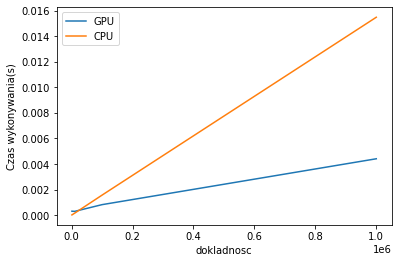

In [11]:
import matplotlib.pyplot as plt
czasgpu = [0.000307,0.000293,0.000820,0.004408]
czascpu = [0.000016,0.000152,0.001566,0.015479]

dokladnosc = [ 1000 ,10000 , 100000 , 1000000]

plt.plot(dokladnosc,czasgpu, label="GPU")
plt.plot(dokladnosc,czascpu, label="CPU")
plt.xlabel("dokladnosc")
plt.ylabel("Czas wykonywania(s)")
plt.legend()
plt.show()

# CPU - trapezy

In [16]:
%%cu
#include<time.h>
#include<stdio.h>

float dokladnosc(int N)
{
    float sum = 0;
    for(int i = 0; i < N-1; ++i)
    {
        float x = (float)i/(float) N;
        float nastepny = (float)(i+1)/(float) N;
        float fx = (x*x+x+2);
        float fx_nastepny = ((nastepny*nastepny+nastepny+2) );
        sum += (fx + fx_nastepny)/2;
    }
    sum *= 1.0f / (float)N;
    return sum;
}
int main(){
    FILE *fp = fopen("trapezycpu1000000.txt", "w");
    clock_t start, stop;
    float calka ; 
    start = clock();
    calka = dokladnosc(1000000);
    stop = clock();
    printf("wartość całki: %f\n", calka);
    printf("czas wykonywania: %lf s", (double)(stop - start) / CLOCKS_PER_SEC);
    fprintf(fp, "%f\n", (double)(stop - start) / CLOCKS_PER_SEC);
    fclose(fp);
    return 0 ; 
}

wartość całki: 2.833448
czas wykonywania: 0.026865 s


# GPU - trapezy

In [7]:
%%cu 
#include<stdio.h>
#include <cuda_runtime.h>
__global__ void integratorKernel(float *a, int N, float h)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    float x = (float)idx / (float)N;
    if(idx < N)
    a[idx] = (x*x+x+2);
}
float licz(int N)
{
    size_t size = N * sizeof(float);
    float* a_h = (float *)malloc(size);
    float* a_d ; cudaMalloc((void **) &a_d, size);
    int block_size = 256;
    int n_blocks = N/block_size + (N % block_size == 0 ? 0:1);
    float h = 1.0f / (float)N;
    integratorKernel <<< n_blocks, block_size >>> (a_d, N, h);
    cudaMemcpy(a_h, a_d, sizeof(float)*N, cudaMemcpyDeviceToHost);
    float sum = (a_h[0] + a_h[N-1]) / 2.0f;
    for (int i=1; i < N-1; i++) sum += a_h[i];
    sum *= h;
    free(a_h); cudaFree(a_d);
    return sum;
}
int main(void){
     FILE *fp = fopen("trapezygpu1000000.txt", "w");
     cudaEvent_t start, stop;
     cudaEventCreate(&start); 
     cudaEventCreate(&stop);
     cudaEventRecord(start, 0);
     float x = licz(1000000);
     cudaEventRecord(stop, 0);
     cudaEventSynchronize(stop);
     float milliseconds = 0;
     cudaEventElapsedTime(&milliseconds, start, stop);
     float seconds = milliseconds / 1000; 
     printf("czas wykonywania: %lf s\n", seconds);
     printf("wartość całki: %f" , x) ;
     fprintf(fp, "%f\n", seconds);
     fclose(fp);
     cudaEventDestroy(start);
     cudaEventDestroy(stop); 
     
     return 0 ; 

}

czas wykonywania: 0.004334 s
wartość całki: 2.833448


# Porównanie

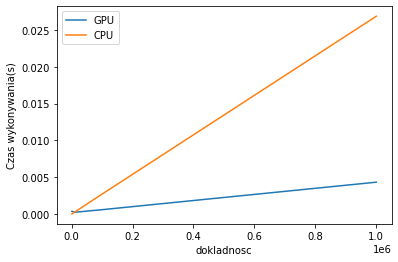

In [14]:
import matplotlib.pyplot as plt
czasgpu = [0.000385,0.000253,0.000602,0.0043345]
czascpu = [0.000027,0.000279,0.002717,0.026865]

dokladnosc = [ 1000 ,10000 , 100000 , 1000000]

plt.plot(dokladnosc,czasgpu, label="GPU")
plt.plot(dokladnosc,czascpu, label="CPU")
plt.xlabel("dokladnosc")
plt.ylabel("Czas wykonywania(s)")
plt.legend()
plt.show()

# CPU - Simpson

In [20]:
%%cu
#include<time.h>
#include<stdio.h>
float dokladnosc(int N)
{
    float sum = 0;
    for(int i = 0; i < N-1; i+=1)
    {
        float x = (float)i/(float) N;
        float srodkowy = (float)(i+1)/(float) N;
        float nastepny = (float)(i+2)/(float) N;
        float fx = (x*x+x+2);
        float fx_srodkowy = (srodkowy*srodkowy+srodkowy+2);
        float fx_nastepny = (nastepny*nastepny+nastepny+2);
        sum +=(fx + 4*fx_srodkowy + fx_nastepny)/6;
}
sum *= 1.0f/(float)N;
return sum;
}

int main(){
    FILE *fp = fopen("simpsoncpu1000000.txt", "w");
    clock_t start, stop;
    float calka ; 
    start = clock();
    calka = dokladnosc(1000000);
    stop = clock();
    printf("wartość całki: %f\n", calka);
    printf("czas wykonywania: %lf s", (double)(stop - start) / CLOCKS_PER_SEC);
    fprintf(fp, "%f\n", (double)(stop - start) / CLOCKS_PER_SEC);
    fclose(fp);
return 0 ; 
}


wartość całki: 2.833449
czas wykonywania: 0.032390 s


# GPU - Simpson

In [11]:
%%cu 
#include<stdio.h>
#include <cuda_runtime.h>
__global__ void integratorKernel(float *a, int N, float h)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    float x = (float)idx / (float)N;
    if(idx < N)
    a[idx] = (x*x+x+2);
}
float licz(int N)
{
    size_t size = N * sizeof(float);
    float* a_h = (float *)malloc(size);
    float* a_d ; cudaMalloc((void **) &a_d, size);
    int block_size = 256;
    int n_blocks = N/block_size + (N % block_size == 0 ? 0:1);
    float h = 1.0f / (float)N;
    integratorKernel <<< n_blocks, block_size >>> (a_d, N, h); 
    cudaMemcpy(a_h, a_d, sizeof(float)*N, cudaMemcpyDeviceToHost);
    float sum = a_h[0] + a_h[N-1];
    for (int i=1; i < N-1; i++)
    {
        if (i % 2 == 0)
        sum += 2 * a_h[i];
        else
        sum += 4 * a_h[i];
    }
    sum *= h / 3.0f;
    free(a_h); cudaFree(a_d);
    return sum;
}
int main(void){
    FILE *fp = fopen("simpsongpu1000000.txt", "w");
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start, 0);
    float x = licz(1000000);
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    float seconds = milliseconds / 1000;
    printf("czas wykonywania: %f s\n", seconds);
    printf("wartość całki: %f" , x) ;
    fprintf(fp, "%f\n", seconds);
    fclose(fp);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
    return 0 ; 

}

czas wykonywania: 0.004137 s
wartość całki: 2.833904


# Porównanie

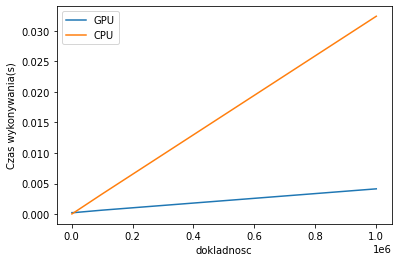

In [12]:
import matplotlib.pyplot as plt
czasgpu = [0.000239,0.000253,0.000646,0.004137]
czascpu = [0.000032,0.000320,0.003287,0.032390]

dokladnosc = [ 1000 ,10000 , 100000 , 1000000]

plt.plot(dokladnosc,czasgpu, label="GPU")
plt.plot(dokladnosc,czascpu, label="CPU")
plt.xlabel("dokladnosc")
plt.ylabel("Czas wykonywania(s)")
plt.legend()
plt.show()

#Wnioski
Jak możemy zauważyć na wykresach GPU jest znacznie szybsze niż CPU, szczególne różnice w czasach wykonywania możemy zaobserwować przy największych wartościach N możemy więc powiedzieć że CPU jest lepsze w prostych obliczeniach natomiast do tych bardziej skomplikowanych lepiej jest zastosować GPU